# Determine Contribution of Metadata to Feature Differences

We perform an analysis of variance (ANOVA) model to determine if metadata information or real biology treatments contribute to observed differences in each cell painting feature.

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(broom))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(ggrepel))

source(file.path("scripts", "signature_utils.R"))

## Evaluate Clone A and E Dataset

### Load Dataset

In [2]:
col_types <- readr::cols(
    .default = readr::col_double(),
    Metadata_CellLine = readr::col_character(),
    Metadata_Dosage = readr::col_double(),
    Metadata_Plate = readr::col_character(),
    Metadata_Well = readr::col_character(),
    Metadata_batch = readr::col_character(),
    Metadata_plate_map_name = readr::col_character(),
    Metadata_clone_type = readr::col_character()
)

profile_dir <- file.path("..", "2.describe-data", "data", "merged")
profile_file <- file.path(profile_dir, "combined_cloneAcloneE_dataset_feature_select.csv")

# Load Data and subset to only untreated samples
cloneAE_data_df <- readr::read_csv(profile_file, col_types = col_types) %>%
    dplyr::filter(Metadata_Dosage == 0)

print(dim(cloneAE_data_df))
head(cloneAE_data_df, 3)

[1]  18 252


Metadata_CellLine,Metadata_Dosage,Metadata_Plate,Metadata_Well,Metadata_batch,Metadata_plate_map_name,Metadata_clone_type,Cells_AreaShape_Compactness,Cells_AreaShape_Orientation,Cells_AreaShape_Solidity,⋯,Nuclei_Texture_Correlation_DNA_10_03,Nuclei_Texture_Correlation_ER_10_01,Nuclei_Texture_Correlation_ER_20_03,Nuclei_Texture_Correlation_Mito_10_03,Nuclei_Texture_Correlation_Mito_20_00,Nuclei_Texture_Correlation_RNA_10_01,Nuclei_Texture_Correlation_RNA_10_02,Nuclei_Texture_Correlation_RNA_10_03,Nuclei_Texture_Correlation_RNA_20_00,Nuclei_Texture_SumVariance_ER_20_01
<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
WT,0,207106_exposure320,B02,2019_03_20_Batch2,PlateMap_207106_exposure320,wildtype,1.325917,0.3509693,-0.7018227,⋯,0.6356020,-0.1157385,0.6547877,-0.2436284,-0.03041953,-0.03954677,0.16212860,0.4842996,1.172104,-0.6436494
WT,0,207106_exposure320,B03,2019_03_20_Batch2,PlateMap_207106_exposure320,wildtype,1.164187,-0.0542543,-0.7887045,⋯,0.9887432,-0.1965323,0.9756872,-0.2256564,-0.03041953,-0.06884860,-0.17084220,0.5237930,1.172104,-0.6342011
WT,0,207106_exposure320,B04,2019_03_20_Batch2,PlateMap_207106_exposure320,wildtype,1.127666,1.6991615,-0.6179130,⋯,0.5811762,0.1585841,0.6269459,-0.2148418,-0.03041953,-0.16373140,-0.08724707,0.4574436,0.766137,-0.6280405


In [3]:
table(
    cloneAE_data_df$Metadata_batch,
    cloneAE_data_df$Metadata_CellLine,
    cloneAE_data_df$Metadata_Dosage
    )

, ,  = 0

                       
                        CloneA CloneE WT
  2019_02_15_Batch1_20X      3      3  3
  2019_03_20_Batch2          3      3  3


### Perform Linear Model to Determine Sources of Variation

In [4]:
cloneAE_formula_terms <- paste(
    "~",
    "Metadata_clone_type", "+",
    "Metadata_batch", "+",
    "Metadata_Plate", "+",
    "Metadata_CellLine"
)

cloneAE_full_results <- perform_anova(cloneAE_data_df, cloneAE_formula_terms)

### Process Results - Metadata Variation

In [5]:
cloneAE_full_results_df <- cloneAE_full_results[["full_results_df"]]

cloneAE_full_results_df$term <- factor(
    cloneAE_full_results_df$term, levels = c(
        "Metadata_batch",
        "Metadata_Plate",
        "Metadata_CellLine",
        "Metadata_clone_type"
    )
)

cloneAE_full_results_df <- cloneAE_full_results_df %>%
    dplyr::arrange(desc(neg_log_p))

print(dim(cloneAE_full_results_df))
head(cloneAE_full_results_df, 6)

[1] 735   8


term,df,sumsq,meansq,statistic,p.value,feature,neg_log_p
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
Metadata_batch,1,0.29124814,0.29124814,2.331164e+33,5.902205e-227,Cytoplasm_Correlation_Manders_ER_AGP,226.22899
Metadata_batch,1,0.09684646,0.09684646,1.608812e+32,7.915642e-219,Cytoplasm_Correlation_Manders_DNA_RNA,218.10151
Metadata_batch,1,0.31092052,0.31092052,7.439825e+31,1.750187e-216,Cells_Correlation_Manders_RNA_AGP,215.75692
Metadata_batch,1,0.24158138,0.24158138,4.467761e+31,6.214323e-215,Cells_Correlation_Manders_Mito_ER,214.20661
Metadata_batch,1,0.14660079,0.14660079,7.266081e+02,1.821910e-13,Cells_Correlation_Manders_RNA_ER,12.73947
Metadata_clone_type,1,6.52660498,6.52660498,3.402218e+02,3.211753e-11,Cytoplasm_Texture_InfoMeas1_ER_20_01,10.49326


### Process Results - PostHoc Tests

In [6]:
cloneAE_aov <- cloneAE_full_results[["aovs"]]
full_tukey_results_df <- process_tukey(cloneAE_aov, unique(cloneAE_full_results_df$feature))

print(dim(full_tukey_results_df))
head(full_tukey_results_df)

[1] 1225    8


term,comparison,estimate,conf.low,conf.high,adj.p.value,feature,neg_log_p
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
Metadata_clone_type,wildtype-resistant,0.0000000,-1.198669e-17,1.198669e-17,1.00000e+00,Cytoplasm_Correlation_Manders_ER_AGP,0.00000
Metadata_batch,2019_03_20_Batch2-2019_02_15_Batch1_20X,0.2544048,2.544048e-01,2.544048e-01,3.08642e-14,Cytoplasm_Correlation_Manders_ER_AGP,13.51054
Metadata_CellLine,CloneE-CloneA,0.0000000,-1.689020e-17,1.689020e-17,1.00000e+00,Cytoplasm_Correlation_Manders_ER_AGP,0.00000
Metadata_CellLine,WT-CloneA,0.0000000,-1.689020e-17,1.689020e-17,1.00000e+00,Cytoplasm_Correlation_Manders_ER_AGP,0.00000
Metadata_CellLine,WT-CloneE,0.0000000,-1.689020e-17,1.689020e-17,1.00000e+00,Cytoplasm_Correlation_Manders_ER_AGP,0.00000
Metadata_clone_type,wildtype-resistant,0.0000000,-2.631136e-17,2.631136e-17,1.00000e+00,Cytoplasm_Correlation_Manders_DNA_RNA,0.00000


## Visualize Results

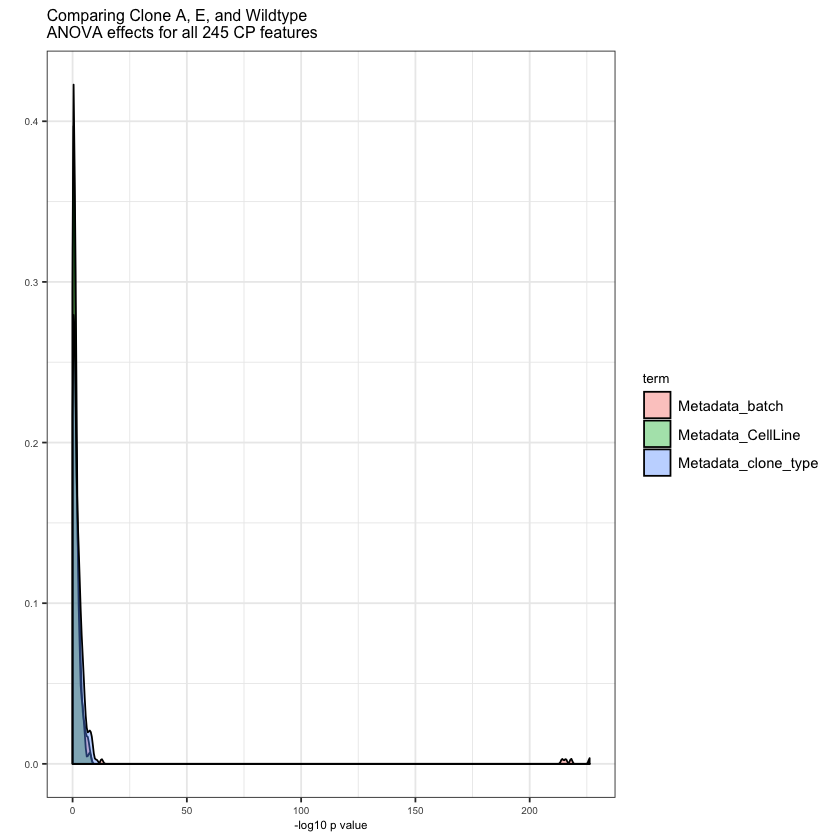

In [7]:
num_cp_features <- length(unique(cloneAE_full_results_df$feature))

difference_contribution_gg <- ggplot(cloneAE_full_results_df,
                                     aes(x = neg_log_p)) +
    geom_density(aes(fill = term), alpha = 0.4) +
    theme_bw() +
    xlab("-log10 p value") +
    ylab("") +
    ggtitle(
        paste("Comparing Clone A, E, and Wildtype\nANOVA effects for all", 
               num_cp_features,
              "CP features")) +
    theme(axis.text = element_text(size = 6),
          axis.title = element_text(size = 7),
          title = element_text(size = 8))

out_file <- file.path("figures", "cloneAE_anova_effect_term_distributions.png")
ggsave(out_file, dpi = 500, height = 5, width = 4)

difference_contribution_gg

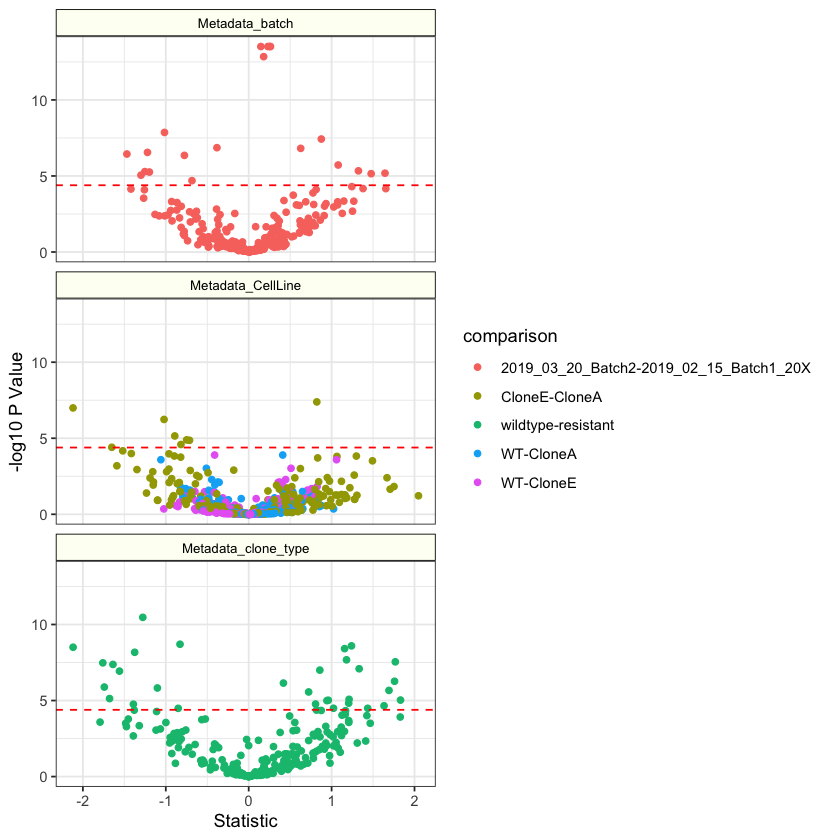

In [8]:
signif_line <- -log10(0.05 / nrow(full_tukey_results_df))

tukey_volcano_gg <- ggplot(full_tukey_results_df, aes(x = estimate, y = neg_log_p)) +
    geom_point(aes(color = comparison)) +
    geom_hline(yintercept = signif_line, color="red", linetype="dashed") +
    facet_wrap("~term", nrow=length(unique(full_tukey_results_df$term))) +
    theme_bw() +
    xlab("Statistic") +
    ylab("-log10 P Value") +
    theme(strip.text = element_text(size = 8, color = "black"),
          strip.background = element_rect(colour = "black", fill = "#fdfff4"))

out_file <- file.path("figures", "cloneAE_tukey_volcano.png")
ggsave(out_file, dpi = 500, height = 5, width = 8)

tukey_volcano_gg

### Identify Feature Signature

In [9]:
feature_exclude_batch <- full_tukey_results_df %>%
    dplyr::filter(term == "Metadata_batch", neg_log_p > !!signif_line) %>%
    dplyr::pull(feature)

feature_exclude_cellline <- full_tukey_results_df %>%
    dplyr::filter(term == "Metadata_CellLine", neg_log_p > !!signif_line) %>%
    dplyr::pull(feature)

signature_features <- full_tukey_results_df %>%
    dplyr::filter(term == "Metadata_clone_type", neg_log_p > !!signif_line) %>%
    dplyr::pull(feature)

signature_features <- setdiff(signature_features, feature_exclude_cellline)
signature_features <- setdiff(signature_features, feature_exclude_batch)

signature_features <- sort(signature_features)

In [10]:
cloneAE_signature_df <- full_tukey_results_df %>%
    dplyr::filter(feature %in% signature_features,
                  term == "Metadata_clone_type")

output_file <- file.path("results", "cloneAE_signature_tukey.tsv")
cloneAE_signature_df %>% readr::write_tsv(output_file)

cloneAE_signature_df

term,comparison,estimate,conf.low,conf.high,adj.p.value,feature,neg_log_p
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
Metadata_clone_type,wildtype-resistant,-2.1181071,-2.4659172,-1.7702969,3.128045e-09,Nuclei_AreaShape_Zernike_6_0,8.504727
Metadata_clone_type,wildtype-resistant,-1.3752331,-1.6147825,-1.1356837,6.727405e-09,Cytoplasm_Granularity_3_Mito,8.172152
Metadata_clone_type,wildtype-resistant,1.7683743,1.4234460,2.1133026,2.849304e-08,Nuclei_AreaShape_Zernike_8_6,7.545261
Metadata_clone_type,wildtype-resistant,-1.7595705,-2.1070736,-1.4120673,3.332788e-08,Nuclei_Texture_AngularSecondMoment_ER_20_01,7.477192
Metadata_clone_type,wildtype-resistant,-1.6372703,-1.9667201,-1.3078205,4.215663e-08,Cytoplasm_Texture_InfoMeas1_DNA_20_01,7.375134
Metadata_clone_type,wildtype-resistant,1.3322792,1.0496410,1.6149174,8.157767e-08,Cells_Correlation_Overlap_DNA_Mito,7.088429
Metadata_clone_type,wildtype-resistant,-1.5587946,-1.8991149,-1.2184744,1.163574e-07,Cytoplasm_Granularity_2_Mito,6.934206
Metadata_clone_type,wildtype-resistant,0.4187734,0.3125825,0.5249643,7.119508e-07,Nuclei_Texture_SumVariance_ER_20_01,6.147550
Metadata_clone_type,wildtype-resistant,-1.7415476,-2.2063617,-1.2767335,1.299652e-06,Nuclei_AreaShape_Zernike_8_2,5.886173


## Four Clone Combined Dataset

### Load Dataset

In [11]:
col_types <- readr::cols(
    .default = readr::col_double(),
    Metadata_Plate = readr::col_character(),
    Metadata_Well = readr::col_character(),
    Metadata_plate_map_name = readr::col_character(),
    Metadata_clone_number = readr::col_character(),
    Metadata_clone_type = readr::col_character(),
    Metadata_plate_ID = readr::col_character(),
    Metadata_plate_filename = readr::col_character(),
    Metadata_treatment = readr::col_character(),
    Metadata_batch = readr::col_character()
)

profile_dir <- file.path("..", "2.describe-data", "data", "merged")
profile_file <- file.path(profile_dir, "combined_four_clone_dataset_feature_select.csv")

# Select only DMSO treatment
fourclone_data_df <- readr::read_csv(profile_file, col_types = col_types) %>%
    dplyr::filter(Metadata_treatment == "DMSO")

print(dim(fourclone_data_df))
head(fourclone_data_df)

[1] 165 315


Metadata_Plate,Metadata_Well,Metadata_batch,Metadata_clone_number,Metadata_plate_ID,Metadata_plate_filename,Metadata_plate_map_name,Metadata_treatment,Metadata_clone_type,Cells_AreaShape_Compactness,⋯,Nuclei_Texture_Correlation_Mito_10_00,Nuclei_Texture_Correlation_Mito_20_02,Nuclei_Texture_Correlation_Mito_20_03,Nuclei_Texture_Correlation_RNA_10_01,Nuclei_Texture_Correlation_RNA_20_02,Nuclei_Texture_Entropy_DNA_20_03,Nuclei_Texture_InfoMeas1_DNA_5_02,Nuclei_Texture_InfoMeas1_ER_20_03,Nuclei_Texture_InfoMeas1_Mito_5_00,Nuclei_Texture_SumAverage_DNA_20_01
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
217760,B02,2019_11_20_Batch6,BZ017,217760,20191120-20191115-HiDensity,217760,DMSO,resistant,0.1892742,⋯,0.1117816,0.80483309,0.43262698,0.6661698,0.73385956,-1.41832975,0.11881920,-0.3747013,-0.6415635,-1.79620537
217760,B03,2019_11_20_Batch6,WT002,217760,20191120-20191115-HiDensity,217760,DMSO,wildtype,-0.2222484,⋯,-0.9916806,0.39321070,1.63445661,-0.4718923,-0.09869343,-1.15569714,-0.08976685,1.4999775,1.4063813,-1.37533513
217760,B04,2019_11_20_Batch6,WT008,217760,20191120-20191115-HiDensity,217760,DMSO,wildtype,-1.2572853,⋯,-0.5076512,0.04082369,0.69194717,-0.1562536,0.20148771,-0.98999410,0.40192987,0.6499627,0.1018065,-0.07752025
217760,B05,2019_11_20_Batch6,WT009,217760,20191120-20191115-HiDensity,217760,DMSO,wildtype,-1.6113280,⋯,0.7451137,0.02194332,0.09797267,1.2519721,-0.30938619,-0.09493631,-1.82934869,-0.1562294,-0.5049571,-1.87612856
217760,B06,2019_11_20_Batch6,BZ018,217760,20191120-20191115-HiDensity,217760,DMSO,resistant,0.7904362,⋯,0.3005823,0.42972583,-0.43337879,0.6771860,0.75052740,-0.82851980,0.15101566,-0.7786262,-1.1045976,-0.29527375
217760,B07,2019_11_20_Batch6,WT011,217760,20191120-20191115-HiDensity,217760,DMSO,wildtype,1.3199675,⋯,0.8726327,-0.02484273,0.55347226,2.2529958,-0.47069492,0.39786004,-2.18560424,0.3844779,-0.7840962,-1.94177535


In [12]:
table(
    fourclone_data_df$Metadata_clone_number,
    fourclone_data_df$Metadata_clone_type,
    fourclone_data_df$Metadata_treatment,
    fourclone_data_df$Metadata_batch
)

, ,  = DMSO,  = 2019_11_19_Batch5

             
              resistant wildtype
  BZ001               3        0
  BZ008               3        0
  BZ017               3        0
  BZ018               3        0
  WT_parental         0        9
  WT002               0        3
  WT008               0        3
  WT009               0        3
  WT011               0        3

, ,  = DMSO,  = 2019_11_20_Batch6

             
              resistant wildtype
  BZ001               6        0
  BZ008               6        0
  BZ017               6        0
  BZ018               6        0
  WT_parental         0       18
  WT002               0        6
  WT008               0        6
  WT009               0        6
  WT011               0        6

, ,  = DMSO,  = 2019_11_22_Batch7

             
              resistant wildtype
  BZ001               6        0
  BZ008               6        0
  BZ017               6        0
  BZ018               6        0
  WT_parental         0   

### Perform Linear Model to Determine Sources of Variation

In [13]:
four_clone_formula_terms <- paste(
    "~",
    "Metadata_clone_type", "+",
    "Metadata_batch", "+",
    "Metadata_clone_number"
)

full_results <- perform_anova(fourclone_data_df, four_clone_formula_terms)

### Process Results - Metadata Variation

In [14]:
full_results_df <- full_results[["full_results_df"]]

full_results_df$term <- factor(
    full_results_df$term, levels = c(
        "Metadata_batch",
        "Metadata_clone_number",
        "Metadata_clone_type"
    )
)

full_results_df <- full_results_df %>%
    dplyr::arrange(desc(neg_log_p))

print(dim(full_results_df))
head(full_results_df, 6)

[1] 918   8


term,df,sumsq,meansq,statistic,p.value,feature,neg_log_p
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
Metadata_clone_type,1,105.98546,105.98546,327.70173,5.688523e-40,Nuclei_RadialDistribution_RadialCV_ER_2of4,39.24500
Metadata_clone_type,1,91.63044,91.63044,258.97279,8.323625e-35,Nuclei_RadialDistribution_RadialCV_AGP_2of4,34.07969
Metadata_clone_type,1,89.00809,89.00809,200.99416,1.002186e-29,Nuclei_RadialDistribution_RadialCV_Mito_2of4,28.99905
Metadata_clone_type,1,68.53438,68.53438,196.61156,2.620625e-29,Nuclei_Texture_InfoMeas1_ER_20_03,28.58160
Metadata_clone_number,7,95.63777,13.66254,34.52399,1.371636e-28,Cytoplasm_Texture_Correlation_Mito_20_00,27.86276
Metadata_clone_number,7,72.80466,10.40067,27.92480,1.568111e-24,Cells_Texture_Correlation_RNA_20_03,23.80462


### Process Results - Post-Hoc Tests

In [15]:
fourclone_aov <- full_results[["aovs"]]
full_tukey_results_df <- process_tukey(fourclone_aov, unique(full_results_df$feature))

print(dim(full_tukey_results_df))
head(full_tukey_results_df)

[1] 12240     8


term,comparison,estimate,conf.low,conf.high,adj.p.value,feature,neg_log_p
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
Metadata_clone_type,wildtype-resistant,-1.66607616,-1.8478912,-1.484261087,0.00000000,Nuclei_RadialDistribution_RadialCV_ER_2of4,Inf
Metadata_batch,2019_11_20_Batch6-2019_11_19_Batch5,-0.06552024,-0.3524636,0.221423122,0.85152303,Nuclei_RadialDistribution_RadialCV_ER_2of4,0.069803602
Metadata_batch,2019_11_22_Batch7-2019_11_19_Batch5,0.10994553,-0.1769978,0.396888899,0.63684620,Nuclei_RadialDistribution_RadialCV_ER_2of4,0.195965441
Metadata_batch,2019_11_22_Batch7-2019_11_20_Batch6,0.17546578,-0.0588225,0.409754054,0.18230284,Nuclei_RadialDistribution_RadialCV_ER_2of4,0.739206574
Metadata_clone_number,BZ008-BZ001,-0.14571742,-0.7991044,0.507669523,0.99870763,Nuclei_RadialDistribution_RadialCV_ER_2of4,0.000561633
Metadata_clone_number,BZ017-BZ001,-0.65412658,-1.3075135,-0.000739636,0.04949942,Nuclei_RadialDistribution_RadialCV_ER_2of4,1.305399874


### Visualize Results

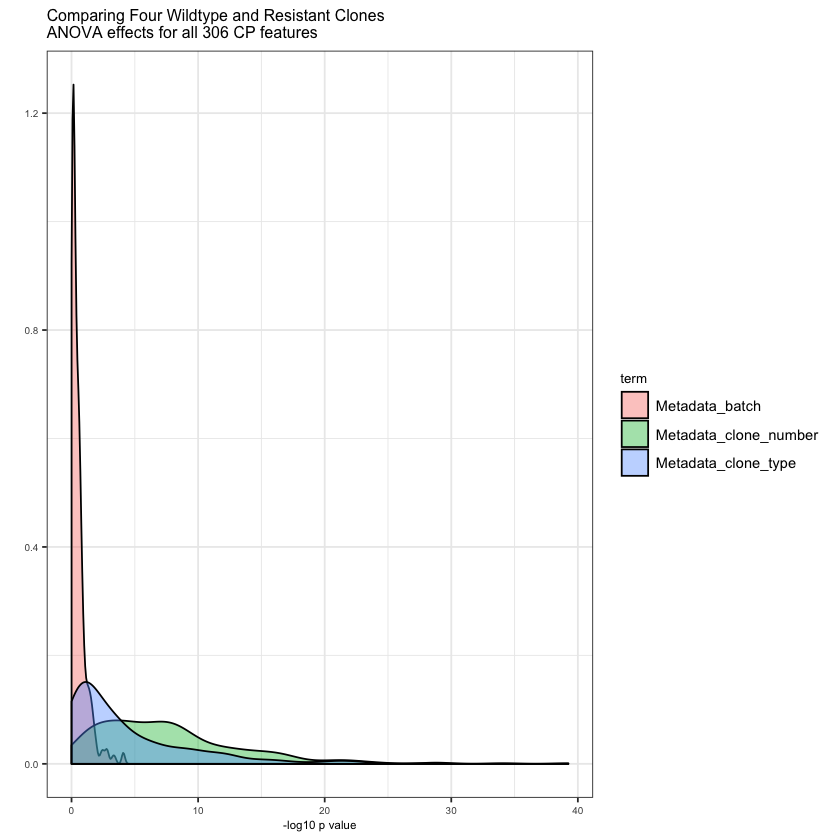

In [16]:
num_cp_features <- length(unique(full_results_df$feature))

difference_contribution_gg <- ggplot(full_results_df,
                                     aes(x = neg_log_p)) +
    geom_density(aes(fill = term), alpha = 0.4) +
    theme_bw() +
    xlab("-log10 p value") +
    ylab("") +
    ggtitle(
        paste("Comparing Four Wildtype and Resistant Clones\nANOVA effects for all", 
               num_cp_features,
              "CP features")) +
    theme(axis.text = element_text(size = 6),
          axis.title = element_text(size = 7),
          title = element_text(size = 8))

out_file <- file.path("figures", "fourclone_anova_effect_term_distributions.png")
ggsave(out_file, dpi = 500, height = 5, width = 4)

difference_contribution_gg

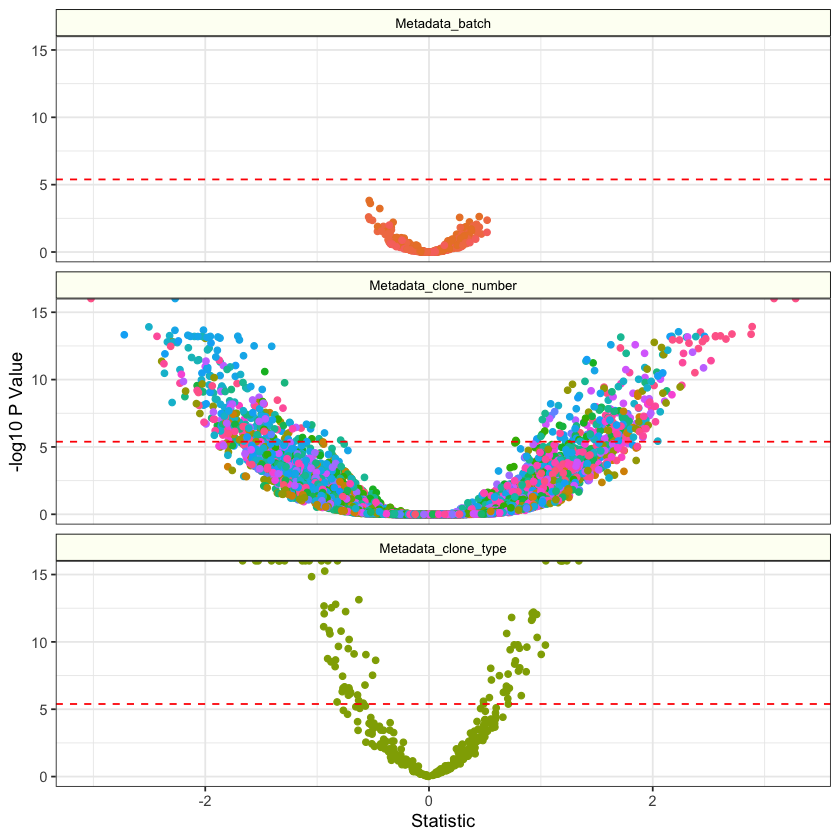

In [17]:
signif_line <- -log10(0.05 / nrow(full_tukey_results_df))

tukey_volcano_gg <- ggplot(full_tukey_results_df, aes(x = estimate, y = neg_log_p)) +
    geom_point(aes(color = comparison)) +
    geom_hline(yintercept = signif_line, color="red", linetype="dashed") +
    facet_wrap("~term", nrow=length(unique(full_tukey_results_df$term))) +
    theme_bw() +
    xlab("Statistic") +
    ylab("-log10 P Value") +
    theme(strip.text = element_text(size = 8, color = "black"),
          strip.background = element_rect(colour = "black", fill = "#fdfff4")) +
    theme(legend.position = "none")

out_file <- file.path("figures", "fourclone_tukey_volcano.png")
ggsave(out_file, dpi = 500, height = 5, width = 4)

tukey_volcano_gg

### Identify Feature Signature

In [18]:
feature_exclude_batch <- full_tukey_results_df %>%
    dplyr::filter(term == "Metadata_batch", neg_log_p > !!signif_line) %>%
    dplyr::pull(feature)

feature_exclude_cellline <- full_tukey_results_df %>%
    dplyr::filter(term == "Metadata_clone_number", neg_log_p > !!signif_line) %>%
    dplyr::pull(feature)

signature_features <- full_tukey_results_df %>%
    dplyr::filter(term == "Metadata_clone_type", neg_log_p > !!signif_line) %>%
    dplyr::pull(feature)

signature_features <- setdiff(signature_features, feature_exclude_cellline)
signature_features <- setdiff(signature_features, feature_exclude_batch)

signature_features <- sort(signature_features)

In [19]:
signature_df <- full_tukey_results_df %>%
    dplyr::filter(feature %in% signature_features,
                  term == "Metadata_clone_type")

output_file <- file.path("results", "fourclone_signature_tukey.tsv")
signature_df %>% readr::write_tsv(output_file)

signature_df

term,comparison,estimate,conf.low,conf.high,adj.p.value,feature,neg_log_p
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
Metadata_clone_type,wildtype-resistant,-1.4081450,-1.6432854,-1.1730045,0.000000e+00,Nuclei_RadialDistribution_RadialCV_ER_1of4,Inf
Metadata_clone_type,wildtype-resistant,-1.3355248,-1.5630956,-1.1079541,0.000000e+00,Nuclei_RadialDistribution_RadialCV_AGP_1of4,Inf
Metadata_clone_type,wildtype-resistant,-1.2903798,-1.5155295,-1.0652301,0.000000e+00,Nuclei_RadialDistribution_RadialCV_Mito_1of4,Inf
Metadata_clone_type,wildtype-resistant,-1.1044089,-1.2994732,-0.9093446,0.000000e+00,Nuclei_RadialDistribution_MeanFrac_ER_1of4,Inf
Metadata_clone_type,wildtype-resistant,-0.9039249,-1.1075821,-0.7002678,0.000000e+00,Cytoplasm_Granularity_3_ER,Inf
Metadata_clone_type,wildtype-resistant,-1.0493953,-1.2899589,-0.8088316,1.443290e-15,Cytoplasm_Granularity_3_AGP,14.840646
Metadata_clone_type,wildtype-resistant,-0.8345836,-1.0383800,-0.6307873,1.618705e-13,Nuclei_AreaShape_Zernike_6_2,12.790832
Metadata_clone_type,wildtype-resistant,0.9337101,0.6990082,1.1684119,6.175060e-13,Nuclei_RadialDistribution_FracAtD_ER_4of4,12.209359
Metadata_clone_type,wildtype-resistant,-0.9366807,-1.1735911,-0.6997703,8.154588e-13,Nuclei_AreaShape_Zernike_8_4,12.088598


## Investigate specific features

In [20]:
feature_focus_df <- full_results_df %>%
    reshape2::dcast(feature ~ term, value.var = "neg_log_p")

head(feature_focus_df)

,feature,Metadata_batch,Metadata_clone_number,Metadata_clone_type
,<chr>,<dbl>,<dbl>,<dbl>
1,Cells_AreaShape_Compactness,0.2438744,21.886586,0.9645505
2,Cells_AreaShape_Extent,0.6947856,14.875113,0.2495849
3,Cells_AreaShape_FormFactor,0.2700228,16.589329,9.1073882
4,Cells_AreaShape_Zernike_0_0,0.5517095,23.782579,0.2026072
5,Cells_AreaShape_Zernike_1_1,1.3211879,2.656193,4.8516511
6,Cells_AreaShape_Zernike_2_0,0.7425812,7.880746,4.2076151


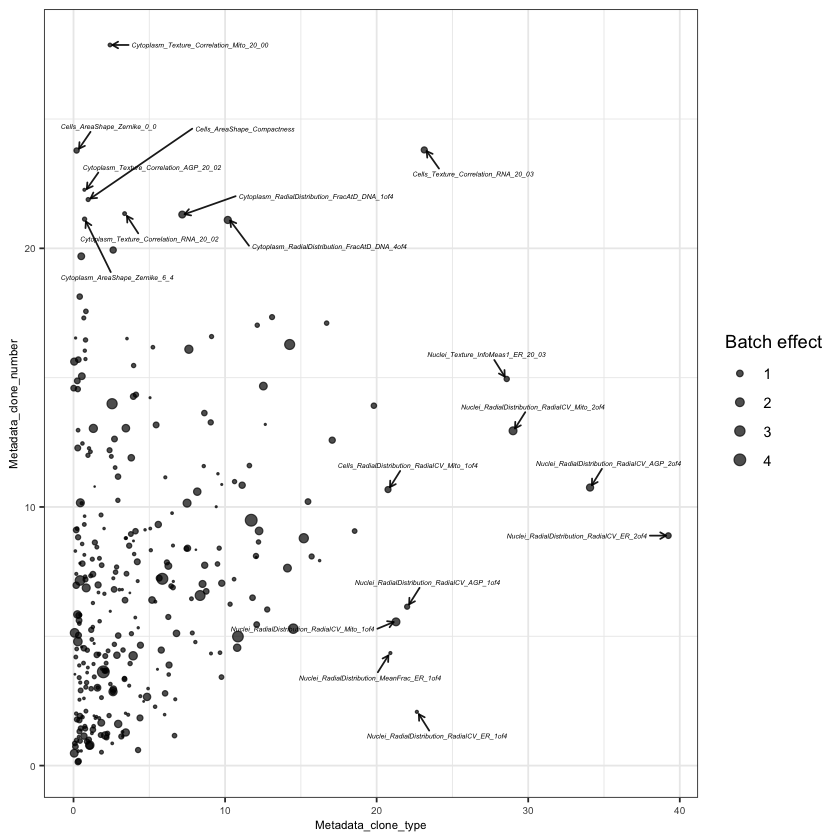

In [21]:
label_logic <- (
    (
        feature_focus_df$Metadata_clone_type > 20
    ) | (
        feature_focus_df$Metadata_clone_number > 20
    )
    )

feature_interpret_gg <- ggplot(feature_focus_df,
       aes(x = Metadata_clone_type,
           y = Metadata_clone_number,
           size = Metadata_batch)) +
    geom_point(alpha = 0.7) + 
    geom_text_repel(data = subset(feature_focus_df, label_logic),
                    arrow = arrow(length = unit(0.01, "npc")),
                    box.padding = 0.7,
                    point.padding = 0.2,
                    segment.size = 0.5,
                    segment.alpha = 0.9,
                    size = 1.45,
                    fontface = "italic",
                    aes(label = feature,
                        x = Metadata_clone_type,
                        y = Metadata_clone_number)) +
    scale_size_continuous(name = "Batch effect", range = c(0.1, 3)) +
    theme_bw() +
    theme(axis.text = element_text(size = 6),
          axis.title = element_text(size = 7))

out_file <- file.path("figures", "fourclone_anova_effect_term_features_clone_vs_treatment.png")
ggsave(out_file, dpi = 400, height = 5, width = 5)

feature_interpret_gg

## Visualize Signatures

Warning message:
“Expected 6 pieces. Missing pieces filled with `NA` in 32 rows [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, ...].”

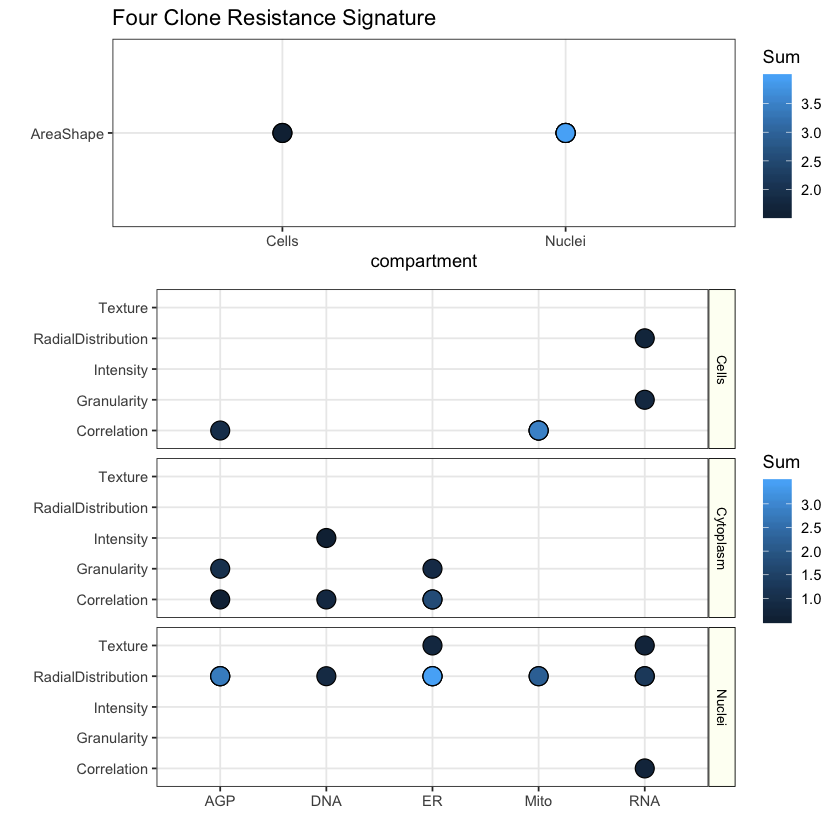

In [22]:
combined_gg <- process_signature_features(
    signature_df, plot_title = "Four Clone Resistance Signature"
)

output_file <- file.path("figures", "fourclone_signature_feature_interpret.png")
cowplot::save_plot(output_file, combined_gg, base_height = 5, base_width = 6, dpi = 500)

combined_gg

Warning message:
“Expected 6 pieces. Missing pieces filled with `NA` in 18 rows [1, 2, 3, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21].”

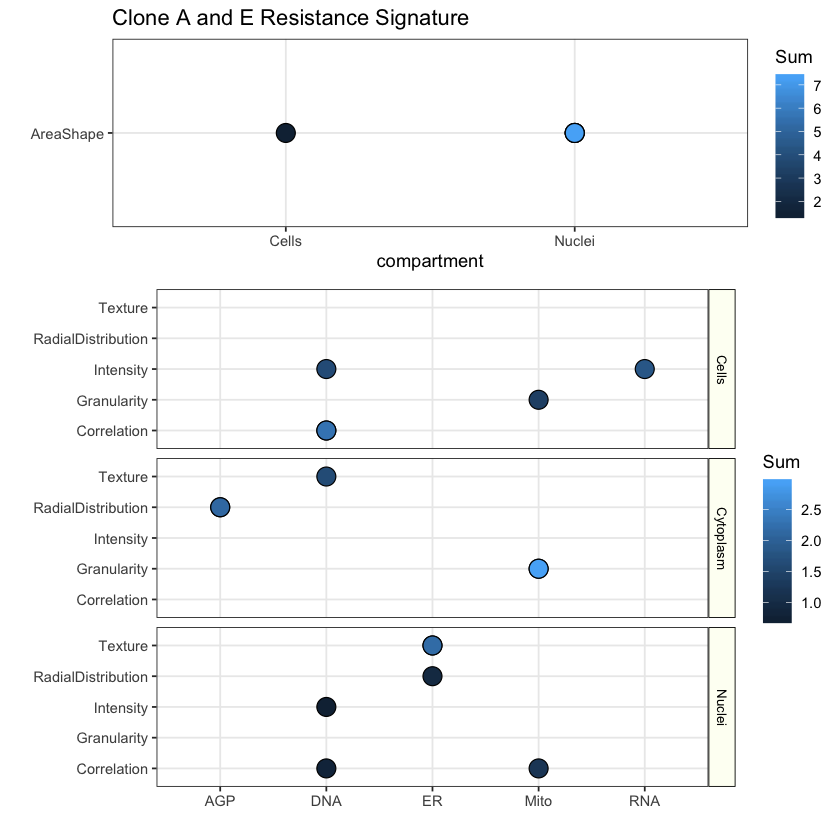

In [23]:
combined_gg <- process_signature_features(
    cloneAE_signature_df, plot_title = "Clone A and E Resistance Signature"
)

output_file <- file.path("figures", "cloneAE_signature_feature_interpret.png")
cowplot::save_plot(output_file, combined_gg, base_height = 5, base_width = 6, dpi = 500)

combined_gg